In [2]:
! apt-get install git

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!git clone https://github.com/RemiVaucher/Thesis

Cloning into 'Thesis'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 472 (delta 1), reused 6 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (472/472), 285.42 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (420/420), done.


In [ ]:
!pip install signatory
!pip install scikit-fda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=11874849 sha256=ba657015a86e8a929b2b5e91d59d08bc9d0979746af45701592fb66fc90eaa53
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.7 MB/s eta 0:00:00


In [3]:
import sys
%cd Thesis/Chapter5
from Algo_Seigal_inverse_path2 import SeigalAlgo, brown


[WinError 3] The system cannot find the path specified: 'Thesis/Chapter5'
c:\Users\AnnaMALET\Documents\Thesis\Chapter5


ModuleNotFoundError: No module named 'signatory'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch


#Define your path to recover



In [ ]:

#size_ts is the number of sample times

size_ts= 100

# T can be important for formulas

T = 5

#Sample times (either random unform or deterministic):

#times = np.random.uniform(low = 0, high = T, size = size_ts)
times = np.linspace(0,T,num = size_ts)

#If you want to recover a dim 1 path : multichan = False. If dim>1, multichan = True (automatic)
multichan = False

# Curve 0 is a polynomial
# Curve 1 is is a cosine
# Curve 2 is a gaussian exponential
# Curve 3 is a noisy circle
# Curve 4 is a one dimensional brownian motion
# Curve 5 is a multidimensional brownian motion (with dim = dim)

curve = 1

if curve==3 or curve == 5:
    multichan = True
sigma = 0.1


#If you want to augment with the length. In this case, ALWAYS fix it to True
length = True


if curve == 0:
    f = lambda t: t**4 - t**3 - 5*t**2 - 8*t + 4 + sigma*np.random.normal(size = size_ts)
    g = lambda t: t**4 - t**3 - 5*t**2 - 8*t + 4
    idx_ts = np.argsort(times)
    traj = f(times[idx_ts])
if curve == 1:
    f = lambda t: np.cos(t)+sigma*np.random.normal(size = size_ts)
    g = lambda t: np.cos(t)
    idx_ts = np.argsort(times)
    traj = f(times[idx_ts])
if curve == 2:
    f = lambda t: np.exp(-(t-3)**2)+sigma*np.random.normal(size = size_ts)
    g = lambda t: np.exp(-(t-3)**2)
    idx_ts = np.argsort(times)
    traj = f(times[idx_ts])
if curve == 3:
    times = np.linspace(0,2*np.pi,num = size_ts)
    f1 = lambda t: np.cos(t)+sigma*np.random.normal(size = size_ts)
    f2 = lambda t: np.sin(t)+sigma*np.random.normal(size = size_ts)
    traj = np.array([f1(times),f2(times)])
    idx_ts = np.argsort(times)
    traj = traj[:,idx_ts]
    times = times[idx_ts]
if curve == 4:
    traj = brown(size = size_ts,sig = 1)
    times = np.linspace(0, 1, num = size_ts)
if curve == 5:
    dim = 5
    traj = brown(size = (size_ts,dim),sig = 1).T
    times = np.linspace(0, 1, num = traj.shape[1])
    idx_ts = np.argsort(times)
    times = times[idx_ts]



In [ ]:
# Creation of augmentation: at the end the shape is (1,size_ts,dim+1) (the first dimension is the batch dim for signatory)
# time_add control the augmentation by time
# We center the path (as the signature is invariant by translation)
time_add = True

if not multichan:
    L = np.abs(traj[1:]-traj[:-1]).cumsum()
    L = np.insert(L,0,0)
    if time_add:
        TS = np.array([times,L,traj-traj[0]]).T
    else:
        TS = np.array([L,traj-traj[0]]).T

else:

    L = np.linalg.norm(traj[:,1:]-traj[:,:-1],axis=0).cumsum(axis=0)
    L = np.insert(L,0,0)
    if time_add:
      TS = torch.cat((torch.tensor(times)[None],torch.tensor(L)[None],torch.tensor(traj-traj[:,0,None])),axis=0).numpy().T
    else:
      TS = torch.cat((torch.tensor(L)[None],torch.tensor(traj-traj[:,0,None])),axis=0).numpy().T


In [ ]:
#Configuration

chan = TS.shape[1]

#len_base is the number of base function. As we use PwLinear base, we chose size_ts-1
len_base = size_ts-1

# Create class
depth = 3
#n_recons and real_chan are deprecated for the moment.
# time_chan indicates if we have time augmentation
SA = SeigalAlgo(TS, len_base, chan, real_chan = 0, depth = 3, n_recons = 2, size_base = len_base+1,time_chan = time_add)

#Available base: "PwLinear", "BSpline", "Fourier"
base_name = "PwLinear"
base = SA.define_base(base_name).flip([-2,-1])

#Number of iteration for optimisation
limits = 20000
#Learning rate (there is a patience schedule)
lrs = 1e-2

#Available optimizers : "Adam", "AdamW" and "LBFGS"
optim = "AdamW"
# params are [lambda_length, lambda_frontier, lambda_levy, lambda_ridge]
# [1,5,0,1] , [5,1,0,1] or the same with lambda_ridge = 0 worked well
params = [1,5,0,0]
pack = "torch"

In [ ]:

# Retrieve A from depth 3 signature. "par" is deprecated for the moment. If cuda is available, compute automatically from cuda.
A = SA.retrieve_coeff_base(base, par = 1, limits = limits, lrs = lrs, opt = optim, params = params)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Step 18334
0.01
tensor(561255.8750, dtype=torch.float64)
Step 18335
0.01
tensor(568614.6250, dtype=torch.float64)
Step 18336
0.01
tensor(566076.5625, dtype=torch.float64)
Step 18337
0.01
tensor(555368.5625, dtype=torch.float64)
Step 18338
0.01
tensor(541536.5000, dtype=torch.float64)
Step 18339
0.01
tensor(534861.5000, dtype=torch.float64)
Step 18340
0.01
tensor(536953.8125, dtype=torch.float64)
Step 18341
0.01
tensor(541939.6250, dtype=torch.float64)
Step 18342
0.01
tensor(544913.2500, dtype=torch.float64)
Step 18343
0.01
tensor(540374.4375, dtype=torch.float64)
Step 18344
0.01
tensor(532920.8125, dtype=torch.float64)
Step 18345
0.01
tensor(524812.5625, dtype=torch.float64)
Step 18346
0.01
tensor(520642.6562, dtype=torch.float64)
Step 18347
0.01
tensor(519911.5625, dtype=torch.float64)
Step 18348
0.01
tensor(520237.3125, dtype=torch.float64)
Step 18349
0.01
tensor(520322.8125, dtype=torch.float64)
Step 18350

In [ ]:
# Recompose signal from A
recomposed_signal = np.matmul(A.detach().numpy(),base[0].detach().numpy().T)


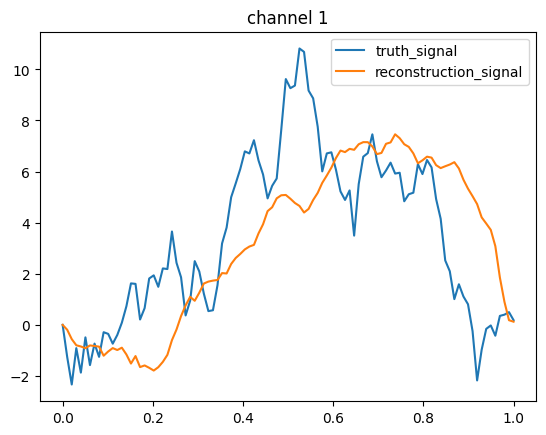

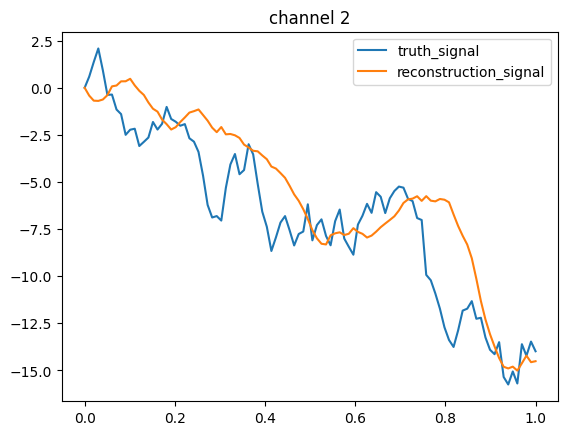

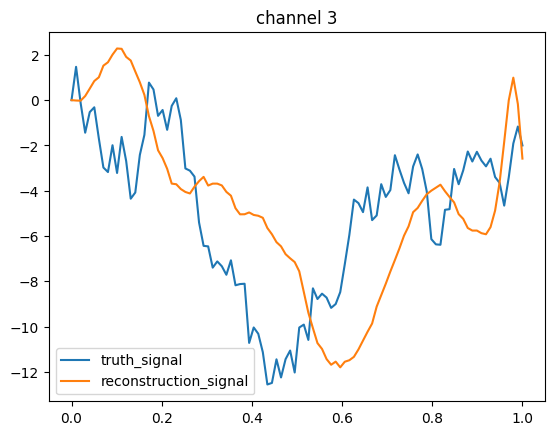

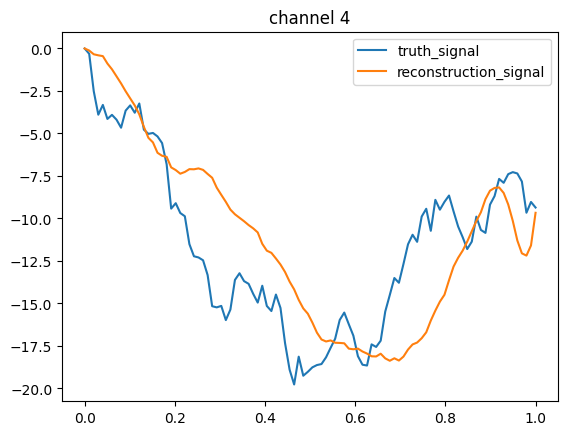

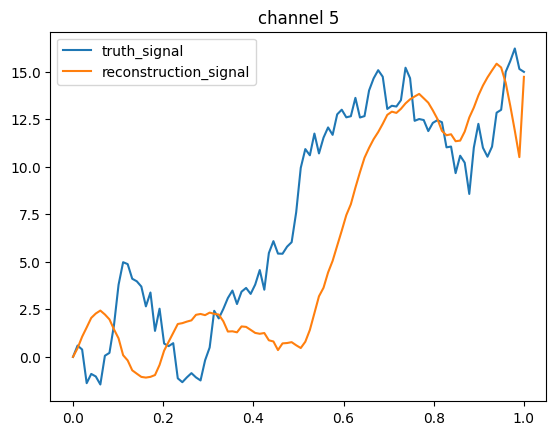

-0.0536417891496116


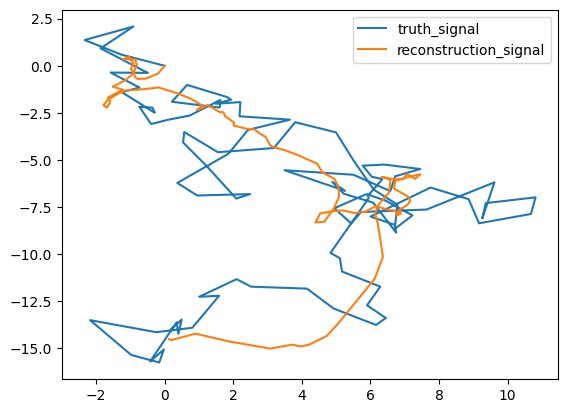

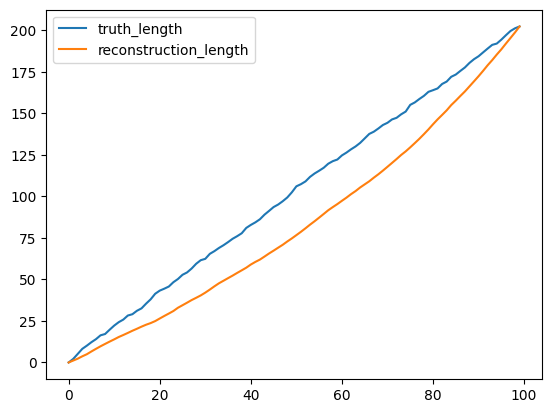

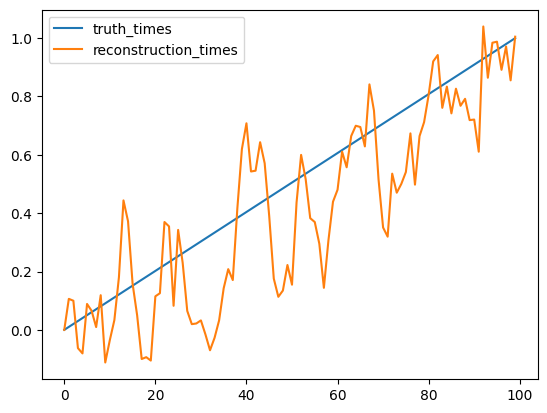

In [ ]:
#See the result

if not multichan:
    if time_add:
        i = 1
    else:
        i=0
    x_axis = np.linspace(0,1,num = recomposed_signal.shape[1])
    plt.plot(x_axis,traj-traj[0])
    plt.plot(x_axis,np.flip(recomposed_signal[i+1,:]))
    plt.legend(['truth_signal','reconstruction_signal'])
    plt.show()
    print(np.mean(traj-traj[0]-recomposed_signal[i+1,:]))

    plt.plot(x_axis,L)
    plt.plot(x_axis,np.flip(recomposed_signal[1,:]))
    plt.legend(['truth_length','reconstruction_length'])
    plt.show()

else:
    x_axis = np.linspace(0,1,num = recomposed_signal.shape[1])
    signal = traj-traj[:,0,None]
    for i in range(traj.shape[0]):
        plt.plot(x_axis,signal[i])
        plt.plot(x_axis,np.flip(recomposed_signal[2+i,:]))
        plt.legend(['truth_signal','reconstruction_signal'])
        plt.title(f"channel {i+1}")
        plt.show()

    print(np.mean(traj-traj[:,0,None]-recomposed_signal[2:,:]))


    plt.plot(signal[0],signal[1])
    plt.plot(np.flip(recomposed_signal[2,:]),np.flip(recomposed_signal[3,:]))
    plt.legend(['truth_signal','reconstruction_signal'])
    plt.show()

    plt.plot(L)
    plt.plot(np.flip(recomposed_signal[1,:]))
    plt.legend(['truth_length','reconstruction_length'])
    plt.show()

    plt.plot(times)
    plt.plot(np.flip(recomposed_signal[0,:]))
    plt.legend(['truth_times','reconstruction_times'])
    plt.show()



